In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 

from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical 
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from keras.layers import Dense, Dropout 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Flatten, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub
import datetime

In [2]:
import os
unique_breeds = []

for folders in os.listdir(r"C:\tmp\stanford-dogs-dataset\images\Images"):
    breed = "".join(folders.split("-")[1:])
    unique_breeds.append(breed)
    
len(unique_breeds), unique_breeds[:10]

(120,
 ['Chihuahua',
  'Japanese_spaniel',
  'Maltese_dog',
  'Pekinese',
  'ShihTzu',
  'Blenheim_spaniel',
  'papillon',
  'toy_terrier',
  'Rhodesian_ridgeback',
  'Afghan_hound'])

# Create a dataset

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\tmp\stanford-dogs-dataset\images\Images",
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\tmp\stanford-dogs-dataset\images\Images",
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

# Visualize the data

In [7]:
"""plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print (labels[i])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(unique_breeds[labels[i]])
    plt.axis("off")"""

    
"""def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(10,16))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(unique_breeds[label_batch[n]==1][0].title(), fontsize=12)
      plt.axis('off')
    
image_batch, label_batch = next(train_data.as_numpy_iterator())
show_batch(image_batch, label_batch)"""

"def show_batch(image_batch, label_batch):\n  fig = plt.figure(figsize=(10,16))\n  for n in range(BATCH_SIZE):\n      ax = plt.subplot(8,4,n+1)\n      plt.imshow(image_batch[n])\n      plt.title(unique_breeds[label_batch[n]==1][0].title(), fontsize=12)\n      plt.axis('off')\n    \nimage_batch, label_batch = next(train_data.as_numpy_iterator())\nshow_batch(image_batch, label_batch)"

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 120)


# Configure the dataset for performance

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Rescale pixel values

In [10]:
# it happened automatically

# Create the model

In [12]:
IMG_SIZE = (224, 224)
# Create the base model from the pre-trained model MobileNet V3
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.9(input_shape=IMG_SHAPE,
                                               weights='imagenet')

In [13]:
base_model.trainable = False

In [14]:
len(base_model.trainable_variables) # Shows that its frozen

0

# Compile the model

In [15]:
#setup input shape into the model
INPUT_SHAPE = [None,IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel

#setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)



# Setup Layers
model = tf.keras.Sequential([
    base_model, # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=512, activation="relu"), # Hidden Layer   
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation="relu"), # Hidden Layer       
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 4 (Output Layer)       
])


# Compiling the model
base_learning_rate = 0.0001
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
      metrics =["accuracy"]
)

# Build Model
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 1000)             5507432   
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 120)               30840     
                                                        

In [16]:
len(model.trainable_variables)

6

# Creating Callbacks


In [2]:
from datetime import datetime

def create_model_checkpoint(dir, suffix=None):
    modeldir = os.path.join(dir, "Models",
                          datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
    
    model_path = modeldir + "-" + suffix
    print(f"Model will be saved to `{model_path}`")
    return tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy',save_best_only=True)

In [18]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)

# Train the model

In [19]:
loss0, accuracy0 = model.evaluate(val_ds)

129/129 [==============================] - 56s 427ms/step - loss: 4.7884 - accuracy: 9.7182e-04


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.79
initial accuracy: 0.00


In [21]:
# EPOCHS
NUM_EPOCHS = 100

# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "stanford_new_best")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Model Training
model_history = model.fit(train_ds,
                    epochs=NUM_EPOCHS,
                    validation_data=val_ds,
                    validation_freq=1,
                    callbacks=[early_stopping, checkpoint],
                )

Model will be saved to `Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best`
Epoch 1/100
515/515 [==============================] - ETA: 0s - loss: 4.5092 - accuracy: 0.4792

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 369s 607ms/step - loss: 4.5092 - accuracy: 0.4792 - val_loss: 3.9796 - val_accuracy: 0.8243
Epoch 2/100
515/515 [==============================] - ETA: 0s - loss: 3.1131 - accuracy: 0.8183

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 315s 613ms/step - loss: 3.1131 - accuracy: 0.8183 - val_loss: 2.0328 - val_accuracy: 0.8756
Epoch 3/100
515/515 [==============================] - ETA: 0s - loss: 1.4385 - accuracy: 0.8597

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 300s 582ms/step - loss: 1.4385 - accuracy: 0.8597 - val_loss: 0.8403 - val_accuracy: 0.8897
Epoch 4/100
515/515 [==============================] - ETA: 0s - loss: 0.8070 - accuracy: 0.8662

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 306s 595ms/step - loss: 0.8070 - accuracy: 0.8662 - val_loss: 0.5835 - val_accuracy: 0.8899
Epoch 5/100
515/515 [==============================] - ETA: 0s - loss: 0.6390 - accuracy: 0.8726

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 315s 612ms/step - loss: 0.6390 - accuracy: 0.8726 - val_loss: 0.5084 - val_accuracy: 0.8912
Epoch 6/100
515/515 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.8742

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 319s 620ms/step - loss: 0.5751 - accuracy: 0.8742 - val_loss: 0.4767 - val_accuracy: 0.8916
Epoch 7/100
515/515 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.8743

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 324s 630ms/step - loss: 0.5488 - accuracy: 0.8743 - val_loss: 0.4581 - val_accuracy: 0.8924
Epoch 8/100
515/515 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.8745

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 330s 641ms/step - loss: 0.5289 - accuracy: 0.8745 - val_loss: 0.4510 - val_accuracy: 0.8958
Epoch 9/100
515/515 [==============================] - 292s 568ms/step - loss: 0.5121 - accuracy: 0.8759 - val_loss: 0.4445 - val_accuracy: 0.8924
Epoch 10/100
515/515 [==============================] - 295s 572ms/step - loss: 0.4977 - accuracy: 0.8798 - val_loss: 0.4375 - val_accuracy: 0.8946
Epoch 11/100
515/515 [==============================] - 293s 569ms/step - loss: 0.4976 - accuracy: 0.8770 - val_loss: 0.4341 - val_accuracy: 0.8933
Epoch 12/100
515/515 [==============================] - 291s 566ms/step - loss: 0.4808 - accuracy: 0.8780 - val_loss: 0.4349 - val_accuracy: 0.8929
Epoch 13/100
515/515 [==============================] - 293s 569ms/step - loss: 0.4784 - accuracy: 0.8794 - val_loss: 0.4284 - val_accuracy: 0.8955
Epoch 14/100
515/515 [==============================] - 293s 570ms/step - loss: 0.4698 - accuracy: 0.8805 - val_loss: 0.4265 -

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 318s 617ms/step - loss: 0.4630 - accuracy: 0.8814 - val_loss: 0.4255 - val_accuracy: 0.8960
Epoch 17/100
515/515 [==============================] - 293s 570ms/step - loss: 0.4601 - accuracy: 0.8818 - val_loss: 0.4231 - val_accuracy: 0.8950
Epoch 18/100
515/515 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.8821

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 321s 624ms/step - loss: 0.4483 - accuracy: 0.8821 - val_loss: 0.4222 - val_accuracy: 0.8963
Epoch 19/100
515/515 [==============================] - 299s 581ms/step - loss: 0.4502 - accuracy: 0.8822 - val_loss: 0.4210 - val_accuracy: 0.8955
Epoch 20/100
515/515 [==============================] - 299s 581ms/step - loss: 0.4487 - accuracy: 0.8836 - val_loss: 0.4214 - val_accuracy: 0.8960
Epoch 21/100
515/515 [==============================] - 298s 579ms/step - loss: 0.4418 - accuracy: 0.8842 - val_loss: 0.4205 - val_accuracy: 0.8948
Epoch 22/100
515/515 [==============================] - 299s 581ms/step - loss: 0.4406 - accuracy: 0.8820 - val_loss: 0.4201 - val_accuracy: 0.8933
Epoch 23/100
515/515 [==============================] - 305s 593ms/step - loss: 0.4359 - accuracy: 0.8825 - val_loss: 0.4192 - val_accuracy: 0.8958
Epoch 24/100
515/515 [==============================] - ETA: 0s - loss: 0.4342 - accuracy: 0.8842

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_02-18_33_23-stanford_new_best\assets


515/515 [==============================] - 321s 624ms/step - loss: 0.4342 - accuracy: 0.8842 - val_loss: 0.4184 - val_accuracy: 0.8965
Epoch 25/100
515/515 [==============================] - 305s 592ms/step - loss: 0.4325 - accuracy: 0.8840 - val_loss: 0.4191 - val_accuracy: 0.8950
Epoch 26/100
515/515 [==============================] - 302s 586ms/step - loss: 0.4287 - accuracy: 0.8842 - val_loss: 0.4179 - val_accuracy: 0.8953
Epoch 27/100
515/515 [==============================] - 325s 632ms/step - loss: 0.4225 - accuracy: 0.8843 - val_loss: 0.4166 - val_accuracy: 0.8953
Epoch 28/100
515/515 [==============================] - 306s 595ms/step - loss: 0.4201 - accuracy: 0.8854 - val_loss: 0.4179 - val_accuracy: 0.8946
Epoch 29/100
515/515 [==============================] - 332s 644ms/step - loss: 0.4206 - accuracy: 0.8833 - val_loss: 0.4186 - val_accuracy: 0.8948
Epoch 30/100
515/515 [==============================] - 331s 644ms/step - loss: 0.4169 - accuracy: 0.8870 - val_loss: 0.4170 

In [26]:
model.save('Stanford_final.h5')

# Model Learning Curves (Accuracy/Loss)

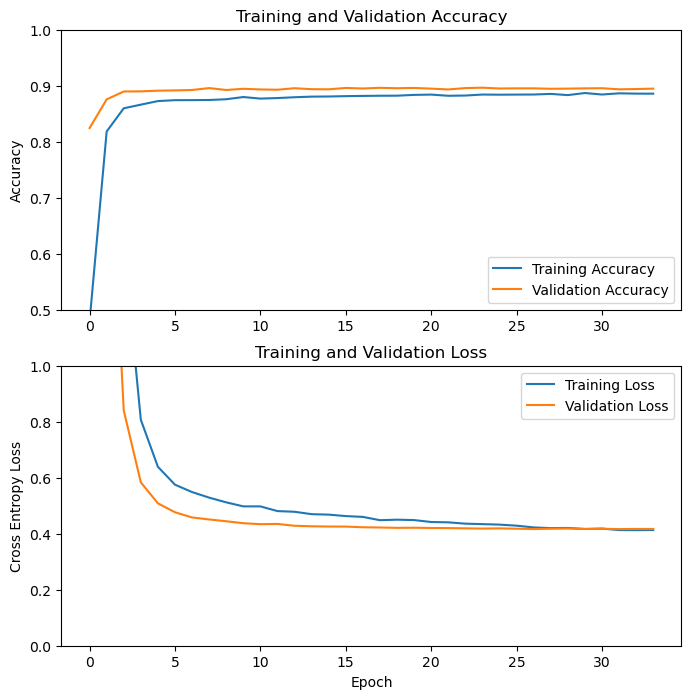

In [23]:
def plot_learning_curves(model_history):
    # retrieve learning metrics history 
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss =model_history.history['val_loss']

    # Plot
    fig = plt.figure(figsize=(8,8))
    ax_acc = plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel("Accuracy")
    plt.ylim([0.5, 1])
    plt.title("Training and Validation Accuracy",)
    
    ax_loss = plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy Loss')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_learning_curves(model_history)

In [31]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(class_names):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [35]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
def download_and_predict(filename):
    
    """test_image_array = img_to_array(test_image)
    new_image = tf.expand_dims(test_image_array,0)
    predicted_batch = model.predict(new_image)
    """
    # download and save
    img = image.load_img(filename, target_size=(224, 224))
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    #img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

1/1 [==============================] - 0s 45ms/step
89.50% 	 malinois
5.97% 	 German_shepherd
0.45% 	 dingo
0.43% 	 Border_terrier
0.31% 	 whippet


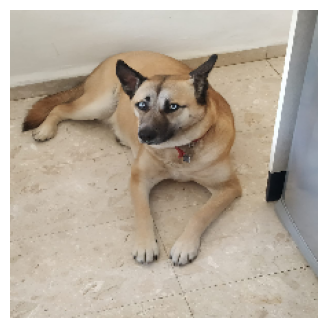

In [48]:
download_and_predict("dog13.jpg")

In [2]:
test_dataset = val_ds.take(val_batches // 5)

NameError: name 'val_ds' is not defined

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)